# Named Entity Recognition with Bi-LSTM

https://github.com/subhasisj/python-projects/blob/master/Machine_Learning_Projects/NLP/Text_classification_Glove_LSTM/Multiclass_text_classification.ipynb

https://www.kaggle.com/alouiamine/ner-using-bidirectional-lstm

https://www.kaggle.com/namanj27/bi-lstm-for-ner-with-liveplotloss

https://www.kaggle.com/abubakaryagob/named-entity-recognition-using-deep-learning

https://www.kaggle.com/tunguz/tensorflow-hub-sentence-embeddings/comments

https://www.kaggle.com/dimitreoliveira/google-quest-eda-and-use-baseline

https://www.kaggle.com/tunguz/tensorflow-hub-sentence-embeddings

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.1'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import pandas as pd
import numpy as np 
import texthero as hero

import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('../Data/ner_dataset.csv',encoding='latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
data.drop(columns=['POS'],inplace=True)

In [7]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   Tag         1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [9]:
data = data.fillna(method='ffill')

In [10]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [11]:
print("unique words; ",data["Word"].nunique())
print("unique tags; ",data["Tag"].nunique())

unique words;  35178
unique tags;  17


In [12]:
from collections import Counter

tag_counts = Counter(data['Tag'])

In [13]:
list(tag_counts)

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

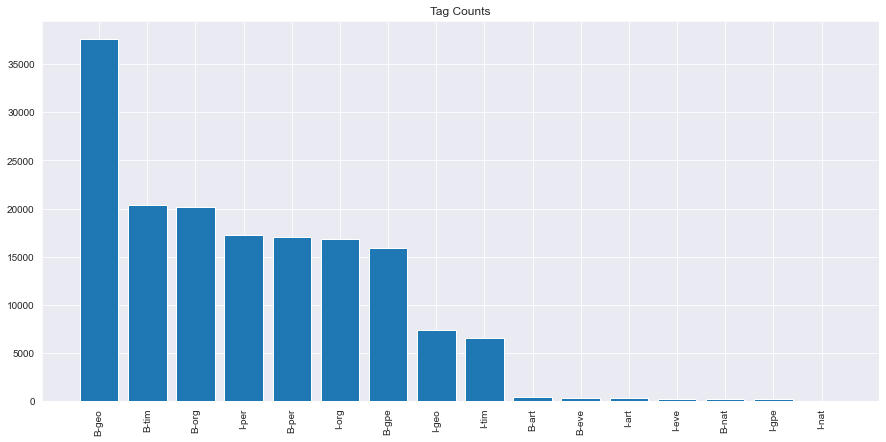

In [14]:
tag_counts = tag_counts.most_common()
tag_counts.pop(0)

plt.figure(figsize=(15,7))
plt.title('Tag Counts')
plt.xticks(rotation='90')
plt.bar(*zip(*tag_counts))
plt.show()

In [15]:
class sentence_getter():
    def __init__(self,data):
        agg_function = lambda s:[(w,t) for w,t in zip(s['Word'].values.tolist(),
                                                      s['Tag'].values.tolist())]
        self.grouped_data = data.groupby('Sentence #').apply(agg_function)
        self.sentences = [s for s in self.grouped_data]

In [16]:
getter = sentence_getter(data)
sentences = getter.sentences
sentences[2]

[('Helicopter', 'O'),
 ('gunships', 'O'),
 ('Saturday', 'B-tim'),
 ('pounded', 'O'),
 ('militant', 'O'),
 ('hideouts', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Orakzai', 'B-geo'),
 ('tribal', 'O'),
 ('region', 'O'),
 (',', 'O'),
 ('where', 'O'),
 ('many', 'O'),
 ('Taliban', 'B-org'),
 ('militants', 'O'),
 ('are', 'O'),
 ('believed', 'O'),
 ('to', 'O'),
 ('have', 'O'),
 ('fled', 'O'),
 ('to', 'O'),
 ('avoid', 'O'),
 ('an', 'O'),
 ('earlier', 'O'),
 ('military', 'O'),
 ('offensive', 'O'),
 ('in', 'O'),
 ('nearby', 'O'),
 ('South', 'B-geo'),
 ('Waziristan', 'I-geo'),
 ('.', 'O')]

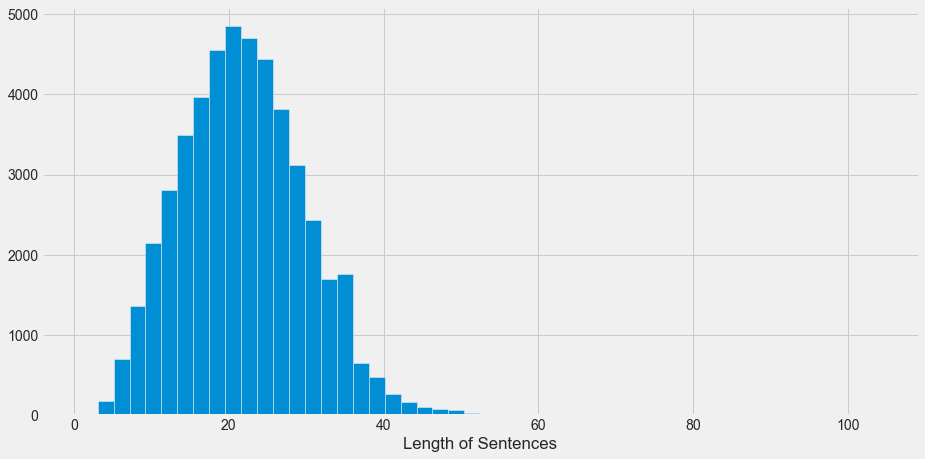

In [17]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentences],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

Most of the words are around 20 words. Longest word is around 50 words. We can use this as padding length.

In [18]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
word_index = {w : i + 1 for i ,w in enumerate(words)}


tags = list(set(data["Tag"].values))
num_tags = len(tags)
tag_index =  {t : i for i ,t in enumerate(tags)}

In [19]:
print(f'Vocabulary size:{n_words}')

Vocabulary size:35179


In [20]:
dict(list(word_index.items())[:15])

{'NIE': 1,
 'mhz': 2,
 'Rocca': 3,
 'disappear': 4,
 'courtroom': 5,
 'Prophet': 6,
 'forged': 7,
 'enrolled': 8,
 'Sambadrome': 9,
 '8956-kilometer': 10,
 'Diyala': 11,
 'Ketzer': 12,
 'prepared': 13,
 'finger': 14,
 'Hearing': 15}

In [21]:

tag_index = {t:i for i,t in enumerate(tags)}
tag_index

{'I-nat': 0,
 'B-art': 1,
 'I-org': 2,
 'I-per': 3,
 'I-gpe': 4,
 'I-eve': 5,
 'B-geo': 6,
 'I-geo': 7,
 'B-nat': 8,
 'I-art': 9,
 'B-tim': 10,
 'B-eve': 11,
 'B-per': 12,
 'B-org': 13,
 'B-gpe': 14,
 'I-tim': 15,
 'O': 16}

In [22]:
word_index['Thousands']

10060

In [23]:
X = [[word_index[w[0]] for w in s] for s in sentences]
X = tf.keras.preprocessing.sequence.pad_sequences(maxlen=50,sequences=X,padding='post', value = n_words - 1)

In [24]:
y = [[tag_index[w[1]] for w in s] for s in sentences]
y = tf.keras.preprocessing.sequence.pad_sequences(maxlen=50,sequences=y,padding='post',value=tag_index['O'])
y = [tf.keras.utils.to_categorical(i,num_classes=num_tags) for i in y]

In [25]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 42)

## Model

In [26]:
from livelossplot.inputs.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 50

model = tf.keras.Sequential([
    # Embedding Layer 
    tf.keras.layers.Embedding(input_dim=len(word_index),output_dim=embedding_dim),
    # Bidiretional LSTM for learning Long term dependencies
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,return_sequences=True)),
    # Dense Layer with RELU
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(embedding_dim,activation='relu')),
    # Ouput layer with 16 units
    tf.keras.layers.Dense(num_tags,activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1758950   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         40400     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 50)          5050      
_________________________________________________________________
dense_1 (Dense)              (None, None, 17)          867       
Total params: 1,805,267
Trainable params: 1,805,267
Non-trainable params: 0
_________________________________________________________________


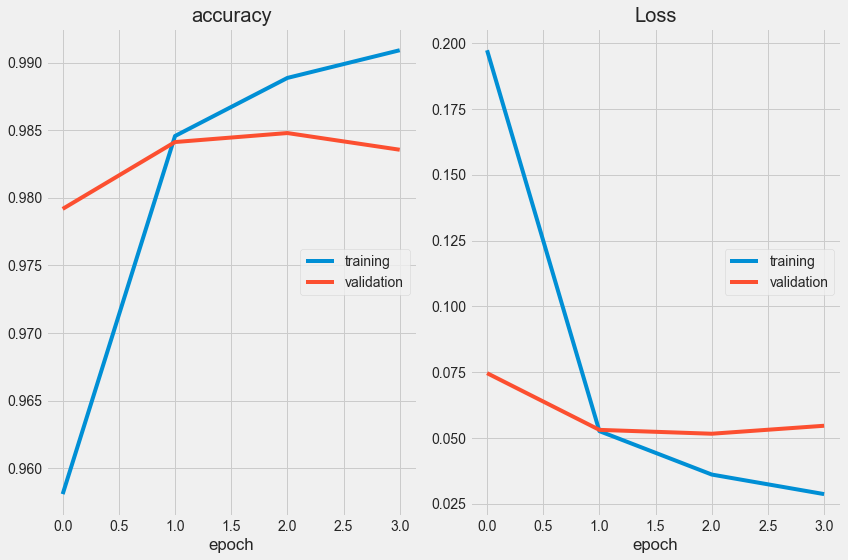

accuracy
	training         	 (min:    0.958, max:    0.991, cur:    0.991)
	validation       	 (min:    0.979, max:    0.985, cur:    0.984)
Loss
	training         	 (min:    0.029, max:    0.197, cur:    0.029)
	validation       	 (min:    0.052, max:    0.075, cur:    0.055)


In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)

history = model.fit(X_train,np.array(y_train),
                    validation_split=0.2,
                    batch_size = 32,
                    epochs = 6,
                    verbose=False,
                    callbacks= [PlotLossesCallback(),early_stopping] )

In [28]:
model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 1s 5ms/step - loss: 0.0542 - accuracy: 0.9838


[0.05419426038861275, 0.9837656617164612]

In [29]:
y_preds = model.predict(X_test)

In [33]:
# Function to decode labels from index
# https://www.kaggle.com/alouiamine/ner-using-bidirectional-lstm

index_tag = {i:w for w,i in tag_index.items()}

def predictions2labels(preds):
    output_tags = []
    for i_pred in preds:
        out_i = []
        for p in i_pred:
            p_i = np.argmax(p)
            out_i.append(index_tag[p_i].replace('PAD','O'))
        output_tags.append(out_i)
    return output_tags

y_preds_tags = predictions2labels(y_preds)
y_test_tags = predictions2labels(y_test)

In [41]:
from seqeval.metrics import precision_score,recall_score,f1_score,classification_report

print(f'F1-Score: {f1_score(y_test_tags,y_preds_tags)*100:,.2f} %')

F1-Score: 78.42 %


In [43]:
precision_score(y_test_tags,y_preds_tags)

0.7630670818954634

In [44]:
recall_score(y_test_tags,y_preds_tags)

0.8065118761676008

In [45]:
from sklearn_crfsuite.metrics import flat_classification_report

report = flat_classification_report(y_pred=y_preds_tags,y_true=y_test_tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        46
       B-eve       0.38      0.17      0.24        35
       B-geo       0.88      0.85      0.86      3796
       B-gpe       0.96      0.93      0.95      1592
       B-nat       0.25      0.10      0.14        20
       B-org       0.65      0.78      0.71      2053
       B-per       0.83      0.77      0.80      1666
       B-tim       0.85      0.91      0.88      2032
       I-art       0.00      0.00      0.00        40
       I-eve       0.53      0.26      0.34        39
       I-geo       0.78      0.78      0.78       712
       I-gpe       0.75      0.38      0.50        16
       I-nat       0.00      0.00      0.00         7
       I-org       0.69      0.82      0.75      1697
       I-per       0.87      0.82      0.85      1657
       I-tim       0.72      0.78      0.75       583
           O       1.00      0.99      1.00    223809

    accuracy              

In [46]:
# Create inference function
def create_input_for_inference(text):
    word_tokens = text.split(' ')
    word_tokens_sequence = [word_index[word] for word in word_tokens]

    predicted_tags = model.predict(np.array(word_tokens_sequence))

    converted_tags = predictions2labels(predicted_tags)

    return word_tokens,converted_tags

In [52]:
test_sentence = 'The US election seems to over and Joe Biden is appearing to be on track for becoming the President of the United States .'

tokens,labels = create_input_for_inference(test_sentence)

In [55]:
for (w, pred) in zip(tokens, labels):
        print("{:20}\t{}".format(w, pred))

The                 	['O']
US                  	['I-org']
election            	['O']
seems               	['O']
to                  	['O']
over                	['O']
and                 	['O']
Joe                 	['I-per']
Biden               	['I-per']
is                  	['O']
appearing           	['O']
to                  	['O']
be                  	['O']
on                  	['O']
track               	['O']
for                 	['O']
becoming            	['O']
the                 	['O']
President           	['B-per']
of                  	['O']
the                 	['O']
United              	['I-geo']
States              	['I-org']
.                   	['O']


In [57]:
# Save model for TF Serving
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = '../Models'
version = 'NER_Model_BiLSTM'
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = ../Models\NER_Model_BiLSTM

INFO:tensorflow:Assets written to: ../Models\NER_Model_BiLSTM\assets

Saved model:


## Improvements:

1-  Use Contextual Word Embeddings

2-  Handle OOV words

3-  Increase accuracy
